In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)


2.2.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [ ]:
dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 7ms/step - loss: 21.5167 - mae: 22.0115 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 21.1522 - mae: 21.6444 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 20.7302 - mae: 21.2236 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 20.2834 - mae: 20.7757 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 19.7897 - mae: 20.2855 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 19.1782 - mae: 19.6696 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 18.2410 - mae: 18.7333 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 17.4825 - mae: 17.9748 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 17.1597 - mae: 17.6529 

(1e-08, 0.0001, 0.0, 30.0)

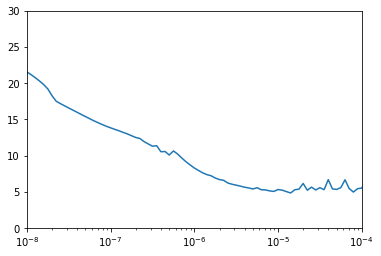

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

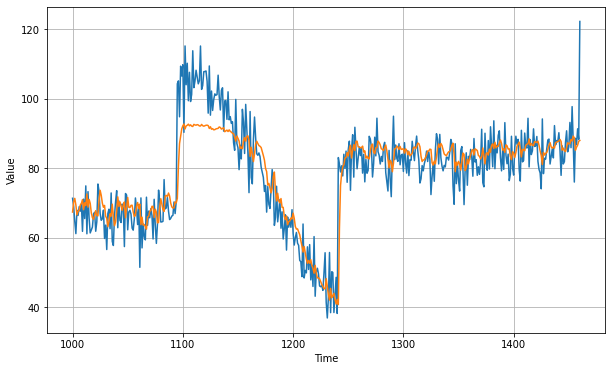

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
import pandas as pd

In [26]:
df=pd.read_csv("data/variables.csv")
df.head()

,date,bitcoin_var,dow_var,euro_stoxx50_var,nasdaq_var,nikkei_var,oro_var,petroleo_var,shangai_stock_exchange_var,sp_500_var
0,2021-01-01,1.42,0.05,-0.53,2.00,-0.45,0.34,0.25,2.17,0.64
1,2020-12-31,0.28,2.10,-0.27,0.77,2.66,0.09,0.83,1.23,0.13
2,2020-12-30,5.45,0.07,0.17,0.23,0.74,0.56,0.80,-0.29,-0.22
3,2020-12-29,1.18,-0.91,0.91,0.18,-0.04,0.13,-1.26,0.31,0.87
4,2020-12-28,3.03,0.07,0.11,0.52,0.54,-0.15,0.23,1.00,0.35


In [27]:
df['date'] =pd.to_datetime(df.date)


In [33]:
df=df.sort_values('date')
df.reset_index()

,index,date,bitcoin_var,dow_var,euro_stoxx50_var,nasdaq_var,nikkei_var,oro_var,petroleo_var,shangai_stock_exchange_var,sp_500_var
0,1124,2017-04-12,3.36,-0.04,-0.13,0.21,-1.85,-0.33,3.26,0.34,-0.09
1,1123,2017-05-12,0.37,-3.09,0.06,0.13,-0.67,-3.21,-2.74,-0.83,0.24
2,1122,2017-06-12,17.85,-1.61,-1.00,0.70,-1.11,-0.06,5.33,0.00,-0.14
3,1121,2017-07-12,22.55,-0.16,-1.18,-0.48,3.98,-1.20,1.66,0.00,0.43
4,1120,2017-08-12,-4.76,2.49,0.50,-0.55,2.46,-0.08,0.86,0.00,-0.36
...,...,...,...,...,...,...,...,...,...,...,...
1120,4,2020-12-28,3.03,0.07,0.11,0.52,0.54,-0.15,0.23,1.00,0.35
1121,3,2020-12-29,1.18,-0.91,0.91,0.18,-0.04,0.13,-1.26,0.31,0.87
1122,2,2020-12-30,5.45,0.07,0.17,0.23,0.74,0.56,0.80,-0.29,-0.22
1123,1,2020-12-31,0.28,2.10,-0.27,0.77,2.66,0.09,0.83,1.23,0.13


In [29]:
df.ix[pd.to_datetime(df.date).order().index]

AttributeError: 'DataFrame' object has no attribute 'ix'